In [ ]:
!nvidia-smi

Wed Mar 13 23:08:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -q seaborn
!pip install -q numpy
!pip install -q pandas
!pip install -q kaggle
!pip install -q scikit-learn

In [ ]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 84.8MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from scipy.sparse import issparse

print(f'Torch: {torch.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Tensorflow: {tf.__version__}')
print(f'Seaborn: {sns.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Sklearn: {sklearn.__version__}')

Torch: 2.2.1+cu121
Numpy: 1.25.2
Pandas: 1.5.3
Tensorflow: 2.15.0
Seaborn: 0.13.1
Matplotlib: 3.7.1
Sklearn: 1.2.2


**DataLoader, Prepprocessing, Pipeline, Model**

In [ ]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_and_inspect(self):
        """
        Load a CSV file and perform basic inspection.
        """
        df = pd.read_csv(self.file_path)
        print("First 5 rows of the DataFrame:")
        print(df.head())
        print("\nDataFrame shape (rows, columns):", df.shape)
        print("\nData types of columns:")
        print(df.dtypes)
        print("\nSummary statistics for numeric columns:")
        print(df.describe())
        return df

In [ ]:
class TensorFlowLinearRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=100, learning_rate=0.01):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = None

    def fit(self, X, y):
        # Debugging line to check the shape of X before conversion
        print("Shape of X before conversion:", X.shape)

        # Check if X is a sparse matrix and convert to dense if necessary
        if issparse(X):
            print("Converting sparse matrix to dense.")
            X = X.toarray()

        # Convert input as numpy array
        X, y = np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

        # Define the model structure
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1, input_shape=(X.shape[1],)),
        ])

        # Compile
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='mse')

        # Fit
        self.model.fit(X, y, epochs=self.epochs, verbose=1)

        return self

    def predict(self, X):
        # Check if X is a sparse matrix and convert to dense if necessary
        if issparse(X):
            X = X.toarray()

        # Convert input as numpy array
        X = np.asarray(X, dtype=np.float32)

        # Make predictions
        predictions = self.model.predict(X)

        return predictions.flatten()


In [ ]:
def create_pipeline(df, epochs=100, learning_rate=0.01):
    # Dynamically determine which columns are numeric and which are categorical
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

    # Define preprocessing for numeric columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    # Combine preprocessing for both types of columns using the column lists
    preprocessor = ColumnTransformer(
        transformers=[
          ('num', numeric_transformer, numeric_cols),
          ('cat', categorical_transformer, categorical_cols)
      ])


    # Assemble the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', TensorFlowLinearRegressor(epochs=epochs, learning_rate=learning_rate))
    ])

    return pipeline

**Load and Inspects**

In [ ]:
train_df_path = '/content/train.csv'
test_df_path = '/content/test.csv'

# Load and inspect the training dataset
train_loader = DataLoader(train_df_path)
train_df = train_loader.load_and_inspect()

# Load and inspect the testing dataset
test_loader = DataLoader(test_df_path)
test_df = test_loader.load_and_inspect()

**Prepare the Pipeline**

In [ ]:
# 'SalePrice' is the target variable
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = np.log(train_df['SalePrice'])
X_test = test_df.drop(['Id'], axis=1)

In [ ]:
# Prepare the pipeline
pipeline = create_pipeline(X_train, epochs=100, learning_rate=0.01)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1460, 79)
(1460,)


In [ ]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Shape of X before conversion: (1460, 245)
Converting sparse matrix to dense.
Epoch 1/100
46/46 [==============================] - 0s 2ms/step - loss: 37.1760
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5483
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.3028
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.2461
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.2185
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1925
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1767
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1644
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1523
Epoch 10/100
46/46 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 0.1344
Epoch 12/100
46/46 [====================

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrL...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('regressor', TensorFlowLinearRegressor())])

In [ ]:
# Predictions in log scale
predictions_log_scale = pipeline.predict(X_test)

# Convert predictions back from log scale
predictions = np.exp(predictions_log_scale)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

predictions_df.head()

46/46 [==============================] - 0s 1ms/step


,Id,SalePrice
0,1461,151136.640625
1,1462,161893.937500
2,1463,202588.500000
3,1464,221153.421875
4,1465,217837.140625


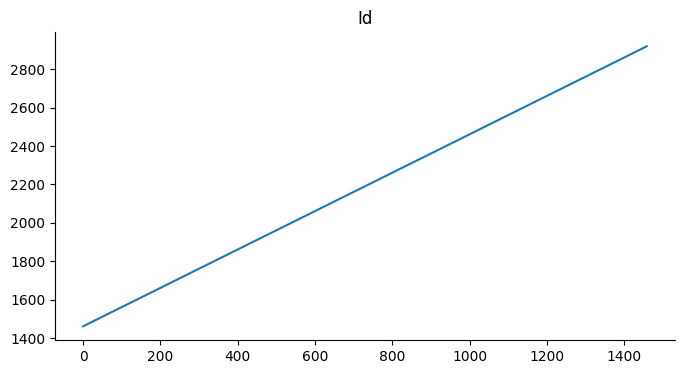

In [ ]:
from matplotlib import pyplot as plt
predictions_df['Id'].plot(kind='line', figsize=(8, 4), title='Id')
plt.gca().spines[['top', 'right']].set_visible(False)